# Rede Convolucional similar a LeNet aplicada no MNIST

Neste notebook iremos utilizar uma rede convolucional similar à rede LeNet para treinar e classificar o conjunto de dados do MNIST.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import time
import numpy as np
import scipy
import argparse

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.datasets import mnist

print('Keras ', keras.__version__)
print('Numpy ', np.__version__)

sys.path.append('../src')
from my_keras_utilities import (load_model_and_history, save_model_and_history, TrainingPlotter)

import os
os.makedirs('../../models',exist_ok=True)

Keras  2.0.4
Numpy  1.12.1


In [2]:
import keras.backend as K

K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:     {}'.format(K.backend()))
print('Data format: {}'.format(K.image_data_format()))


Backend:     tensorflow
Data format: channels_first


## Dataset MNIST

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

# one-hot encoding:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

n_samples_train = 1000
n_samples_test  = 500

X_train = X_train[:n_samples_train]
y_train = y_train[:n_samples_train]
X_test = X_test[:n_samples_test]
y_test = y_test[:n_samples_test]

## Callback especial

In [4]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
    

## Rede neural sem batch-norm

In [5]:
model_name = '../../models/bnorm_mnist_1'

def build_net(width, height, depth, classes):
    # initialize the model
    model = Sequential()

    model.add(Conv2D(20, (5, 5), padding="same", input_shape=(depth, height, width)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model


## Laço de treinamento

In [11]:
# os.unlink(model_name + '.model')
if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = build_net(width=28, height=28, depth=1, classes=10)
    
    # History, checkpoint, earlystop, plot losses:
    my_cb = MyCb(n=1, filepath=model_name, patience=15)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model, my_big_callback = load_model_and_history(model_name)

[INFO] creating model...
[INFO] compiling model...


[INFO] evaluating in the test data set ...
500/500 [==============================] - 0s     
[INFO] accuracy on the test data set: 92.20%


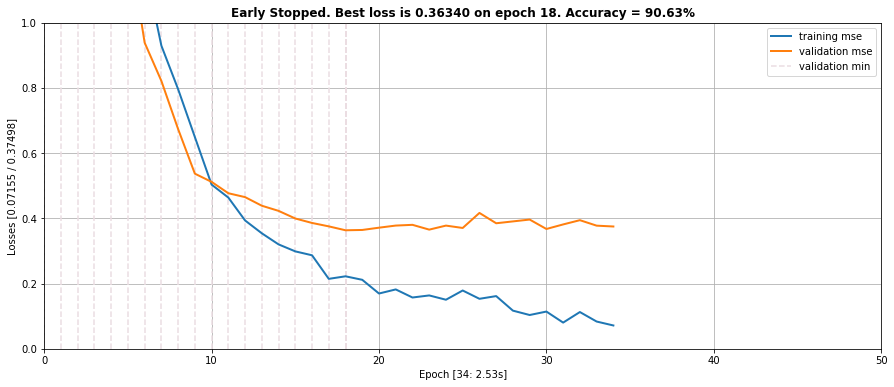

In [12]:
ploss = 1.0
nepochs = 50

past_epochs = my_cb.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nepochs)
plot.grid(True)

print("[INFO] training...")
try:
    histo2 = model.fit(X_train, y_train, batch_size=128, epochs=nepochs - past_epochs, 
                       verbose=0, validation_split=0.33, callbacks=[my_cb])
except KeyboardInterrupt:
    pass

print("[INFO] evaluating in the test data set ...")
loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] accuracy on the test data set: {:.2f}%".format(accuracy * 100))

## Rede neural com batch-norm

In [27]:
model_name_bn = '../../models/bnorm_mnist_bn_1'

def build_net_bn(width, height, depth, classes):
    # initialize the model
    model = Sequential()

    model.add(Conv2D(20, (5, 5), padding="same", input_shape=(depth, height, width)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(BatchNormalization(axis=1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Dropout(0.8))

    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model


In [28]:
os.unlink(model_name + '.model')
if not os.path.isfile(model_name_bn + '.model'):
    print("[INFO] creating model...")
    model_bn = build_net_bn(width=28, height=28, depth=1, classes=10)
    
    # History, checkpoint, earlystop, plot losses:
    my_cb_bn = MyCb(n=1, filepath=model_name, patience=15)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.01, momentum=0.9)
    model_bn.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model_bn, my_cb_bn = load_model_and_history(model_name)

[INFO] creating model...
[INFO] compiling model...


[INFO] evaluating in the test data set ...
500/500 [==============================] - 1s     
[INFO] accuracy on the test data set: 76.40%


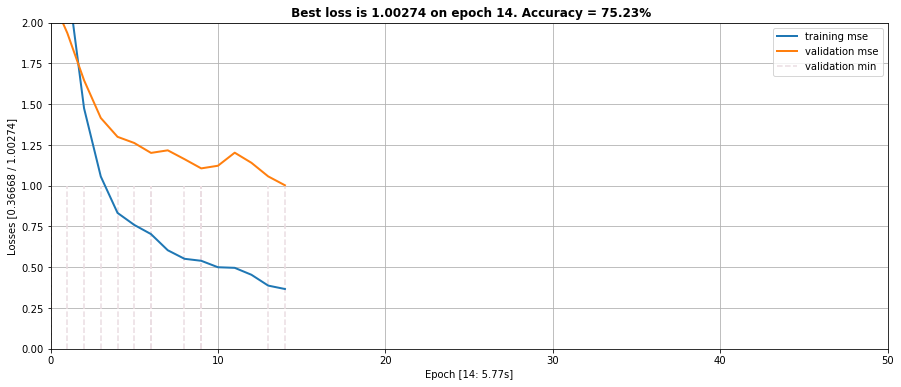

In [29]:
ploss = 2.0
nepochs = 50

past_epochs = my_cb.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nepochs)
plot.grid(True)

print("[INFO] training...")
try:
    histo_bn = model_bn.fit(X_train, y_train, batch_size=128, epochs=nepochs - past_epochs, 
                       verbose=0, validation_split=0.33, callbacks=[my_cb_bn])
except KeyboardInterrupt:
    pass

print("[INFO] evaluating in the test data set ...")
loss, accuracy = model_bn.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] accuracy on the test data set: {:.2f}%".format(accuracy * 100))